# Stateful Functors

Often one will want to perform transformations that keep track of some state. Here we show two ways of doing this.  The first (preferred method) uses a Python Class to define the functor object which is initialized on the local process. The second uses the PipeSystem API to define a graph with a looping topology where the state is stored in the Streams instead of the functor object.

## Simple Moving Average

Here we demonstrate how to use Class functors. All pipe segments may use Class functors as long as the Class has a `run` method implemented. The `run` method plays the role of the standard functor, operating on each data chunk in the stream. Additionally the user may define two other methods `local_init` and `local_term`, which are executed once on the local process on initialization and termination respectively. 

The following example shows how to use a Source and Sink with Class functors. First a random walk is generated from random data, where the location of the previous step is persisted on the local process. Then a moving average is calculated with a queue persisted on the Sink process. Normally only the data in the queue needs to be persisted but for demonstration purposes we persist all values and moving averages to be plotted after the pipeline has terminated. 

In [2]:
from minipipe import Source, Transform, Sink
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

@Source
def generate_rand_walk(n_steps):
    last_step = 0
    for _ in range(n_steps):
        step = np.random.randn() + last_step
        last_step = step
        yield step

@Sink
class simple_moving_average:
    
    def __init__(self, window_size = 10):
        self.window_size = window_size
        self.queue = []
        self.values = []
        self.means = []
    
    @Sink.call
    def window(self, data):
        # Enqueue data
        self.queue.append(data)
        
        # Dequeue data once window size has been reached
        if len(self.queue) > self.window_size:
            self.queue.pop(0)
            
        # Calcualte moving average
        ma = sum(self.queue)/len(self.queue)
        
        # Save values and moving averages for plotting at term
        # Normally you wouldn't save these values bc data scale may cause OOM error
        self.values.append(data)
        self.means.append(ma)
    
    @Sink.term
    def plot(self):
        # This method runs once on the local process at termination
        # Here we simply plot the results 
        steps = range(len(self.values))
        plt.plot(steps, self.values, label='Random Walk')
        plt.plot(steps, self.means, label='Smoothed Walk')
        plt.title('Simple Moving Average')
        plt.xlabel('Steps')
        plt.legend()
        plt.show() # This is necessary since plot in on local process

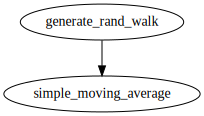

In [6]:
from minipipe import Pipeline

rw = generate_rand_walk(10000)
sma = simple_moving_average(300)

pline = (Pipeline()
         .add(rw)
         .add(sma)
         .build())

pline.diagram()

2020-02-09 18:38:34,704 - INFO - generate_rand_walk - End of stream
2020-02-09 18:38:34,706 - INFO - generate_rand_walk - Local termination
2020-02-09 18:38:34,706 - INFO - simple_moving_average - Local termination


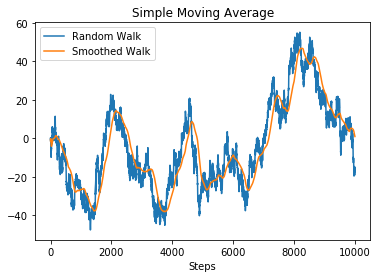

In [7]:
pline.run()

## Fibonacci Sequence with Loops

With the PipeSystem API its possible to build graphs with loops. Loops can be used to store states in a Stream by passing the data back to an upstream. Here's a fun and useless example calculating the Fibonacci sequence with a stateless functor. 

In [23]:
#from multiprocessing import Event
from minipipe import Sentinel

# minipipe uses multiprocessing Events for termination flags
#term_flag = Event() 
n = 1000 # max fib number

@Transform
def fib(x_1, x_2):
    
    print(x_1)
    
    # terminate when n is reached
    if x_2 >= n:
        return Sentinel, Sentinel       
    
    return x_2, x_1 + x_2

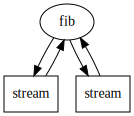

In [24]:
from minipipe import Stream

# initialize streams
strms = [Stream(), Stream()]

# initialize streams instead of using a Source
strms[0].q.put(0) 
strms[1].q.put(1)

# term flag needs to be set explicitly 
#fib.term_flag = term_flag 

pline = Pipeline().add(fib, strms, strms, 3).build()
pline.diagram(True)

In [25]:
pline.run()

0
1
1
2
3
5
8
13
21
34
55
89
144
233
377
610
987


2020-02-09 18:50:21,815 - ERROR - fib - 
2020-02-09 18:50:21,818 - ERROR - fib - Global termination
2020-02-09 18:50:21,819 - ERROR - fib - KeyboardInterrupt
Process fib:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/james/anaconda2/envs/python3/lib/python3.6/site-packages/minipipe/base.py", line 403, in run_pipe
    self._run_loop()
  File "/home/james/anaconda2/envs/python3/lib/python3.6/site-packages/minipipe/pipes.py", line 217, in _run_loop
    raise e
  File "/home/james/anaconda2/envs/python3/lib/python3.6/site-packages/minipipe/pipes.py", line 193, in _run_loop
    x = self._in()
  File "/home/james/anaconda2/envs/python3/lib/python3.6/site-packages/minipipe/base.py", line 284, in _in
    x_i = stream.get()
  File "/home/james/anaconda2/envs/python3/lib/python3.6/site-packages/minipipe/base.py", line 152, in get
    x = self.q.get(timeout=timeout or self.timeout)
  File "/home/james/anaconda2/envs/python3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/james/anaconda2/envs/python3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/hom